In [33]:
import rasterio
from pathlib import Path 
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 0. Data Check
## treepoint data list
- manup_treepoint.shp
- mandown_treepoint.shp
- br_rest1_treepoint.shp
- br_rest2_treepoint.shp

In [34]:
# 1. subclass change function
def sc_change(tp):
    # replace with *
    tp_sc = tp['subclass'].fillna('*')
    
    # subclass string to int
    tp_sc = tp_sc.to_frame()
    sc_list = {'subclass':{'Rosidae':'1', 'Hamamelididae':'2', 'Asteridae':'3',
                           'Dilleniidae':'4', 'Magnoliidae':'5', '*':'6'}}
    tp_sc = tp_sc.replace(sc_list)
    
    # change
    tp.drop(["subclass", "GenusSpeci", "OBJECTID", "Lat", "Long"], axis = 1, inplace=True)
    tp = pd.concat([tp, tp_sc], axis=1)
    
    return tp

In [35]:
# 1. subclass change function
# def sc_change(tp):
#     # subclass string to int
#     tp_sc = tp_sc.to_frame()
#     sc_list = {'family':{'Fabaceae / Leguminosae - Pea family':'1', 'Platanaceae - Plane-tree family':'2', 'Aceraceae - Maple family':'3',
#                          'Fagaceae - Beech family':'4', 'Rosaceae - Rose family':'5', 'Conifer':'6', 'broad-leaf tree':'7'}}
#     tp_sc = tp_sc.replace(sc_list)
    
#     # change
#     tp.drop(["GenusSpecies", "OBJECTID", "Lat", "Long", 'family'], axis = 1, inplace=True)
#     tp = pd.concat([tp, tp_sc], axis=1)
    
#     return tp

In [36]:
## result: ['geo','subclass'(number)] || up(28273,2) down(24128,2) br(33398,2)

# 1. Point Sampling
- NDVI point smapling and Delete under 0.2
- Point Sampling

In [10]:
# 2. Set the feature & area
feature = ['NDVI', 'SBI', 'GVI', 'YVI', 'WBI', 'GCI', 'AVI', 'SIPI', 'ARVI', 'EVI', 
           "MEAN", "VAR", "HOMO", "CONT", "DISSI", "ENTROPY", "SECOND", "CORR"]
area = ['manup', 'mandown', 'br']
# ['NDVI', 'SBI', 'GVI', 'YVI', 'WBI'], 'outglcm_mandown'
# ['NDVI', 'GCI', 'AVI', 'SIPI', 'ARVI', 'EVI']'br', 'brleft', 'manup', 'brup', 'manmid' 'mandown'
# "mean", "variance", "homogeneity", "contrast",  "dissimilarity", "entropy", "second_moment", "correlation"
for i in feature:
    for j in area:
        globals()[f'{i}{j}_file'] = '../KOMPSAT 위성영상/데이터 전처리/4. data/'+j+'/'+i+'.tif'
        globals()[f'{i}{j}_src'] = rasterio.open(globals()[f'{i}{j}_file'])

In [9]:
## result: ['geo','subclass', 'NDVI'] || up(16979,3) down(15042,3) br(24028,3)

In [37]:
# 3. Point Sampling - Store 3by3 geometry
def PSgeo(tp):
    # 가져올 픽셀의 좌표값 설정 (3by3)
    WIDTH = 0.00000599299783809013749338974087784241
    HEIGHT = 0.0000059299783809007439469768700121737
    coord_list0= [(x,y) for x,y in zip(tp['geometry'].x , tp['geometry'].y)]
    coord_list1= [(x-WIDTH, y+HEIGHT) for x,y in zip(tp['geometry'].x , tp['geometry'].y)]
    coord_list2= [(x, y+HEIGHT) for x,y in zip(tp['geometry'].x , tp['geometry'].y)]
    coord_list3= [(x+WIDTH,y+HEIGHT) for x,y in zip(tp['geometry'].x , tp['geometry'].y)]
    coord_list4= [(x+WIDTH,y) for x,y in zip(tp['geometry'].x , tp['geometry'].y)]
    coord_list5= [(x+WIDTH,y-HEIGHT) for x,y in zip(tp['geometry'].x , tp['geometry'].y)]
    coord_list6= [(x,y-HEIGHT) for x,y in zip(tp['geometry'].x , tp['geometry'].y)]
    coord_list7= [(x-WIDTH,y-HEIGHT) for x,y in zip(tp['geometry'].x , tp['geometry'].y)]
    coord_list8= [(x-WIDTH,y) for x,y in zip(tp['geometry'].x , tp['geometry'].y)]
    coord_list = [coord_list0, coord_list1, coord_list2, coord_list3, coord_list4, coord_list5, coord_list6, coord_list7, coord_list8]
    return coord_list

In [38]:
# 3. Point Sampling
def PointSampling(file, src, coord_list):   
    ttp = pd.DataFrame()

    # 3by3에 대한 geometry를 dataframe에 column으로 추가
    ttp['geometry'] = coord_list[0] + coord_list[1] + coord_list[2] + coord_list[3] + coord_list[4] + coord_list[5] + coord_list[6] + coord_list[7] + coord_list[8]

    # 해당 dataframe으로 포인트 샘플링 실행
    ttp[Path(file).stem] = [x for x in src.sample(ttp['geometry'])] # 포인트 샘플링
    ttp[Path(file).stem] = ttp[Path(file).stem].astype('float64') # NDVI 값을 float으로 바꿈
    
    ttp.drop(['geometry'], axis=1, inplace=True)
    
    return ttp

In [39]:
# 3. Point Sampling - make

In [40]:
## 3by3 PS 한번에 돌리려고 했는데 모르겠음
# for i in ['NDVI', 'SBI', 'GVI', 'YVI', 'WBI']:
#     for j in [up, down, br]:
#         PointSampling(globals()[f'{i}{j}_file'], globals()[f'{i}{j}_src'], globals()[f'{j}'])

# 2. Data pretreatment

In [41]:
# 4. delete the 3by3 kernel NDVI values under 0.2 
def NDVIkn02(tp):
    tp.drop(tp[tp['NDVI']<0.2].index, inplace=True)
    tp.reset_index(drop=True, inplace=True)
    return tp

In [42]:
# 5. brleft, manup, mandown 의 subclass 1, 2 지우기
def scdel(tp):
    tp['subclass'] = tp['subclass'].astype(str)
    tem = tp.drop(tp[tp['subclass'] == '1'].index)
    tem = tem.drop(tem[tem['subclass'] == '2'].index)
    return tem

# 3. Run

In [56]:
# data load
tp_up = gpd.GeoDataFrame.from_file("tree_points/manup_treepoint.shp")
# tp_mid = gpd.GeoDataFrame.from_file("tree_points/manmid.shp")
tp_down = gpd.GeoDataFrame.from_file("tree_points/mandown_treepoint.shp")
# tp_br1 = gpd.GeoDataFrame.from_file("tree_points/br_rest1_treepoint.shp")
# tp_br2 = gpd.GeoDataFrame.from_file("tree_points/br_rest2_treepoint.shp")
# tp_brup = gpd.GeoDataFrame.from_file("tree_points/brup.shp")
# tp_brleft = gpd.GeoDataFrame.from_file("tree_points/brleft.shp")
# tp_br = gpd.GeoDataFrame( pd.concat( [tp_br1, tp_br2], ignore_index=True) )

tp_brtest = gpd.GeoDataFrame.from_file("tree_points/br_test_treepoint.shp")
tp_brtest_peak = gpd.GeoDataFrame.from_file("br_test_peak/br_test_peak_last.shp")

In [50]:
# 1. run subclass change
manup = sc_change(tp_up)
mandown = sc_change(tp_down)
# br = sc_change(tp_br)
# brleft = sc_change(tp_brleft)
brtest = sc_change(tp_brtest)

In [51]:
manup

,geometry,subclass
0,POINT (-73.95018 40.80481),1
1,POINT (-73.95173 40.80921),2
2,POINT (-73.94942 40.80449),1
3,POINT (-73.95062 40.80500),2
4,POINT (-73.95038 40.80490),2
...,...,...
28268,POINT (-73.93497 40.79337),2
28269,POINT (-73.92472 40.81457),2
28270,POINT (-73.92858 40.81350),2
28271,POINT (-73.92467 40.81464),2


In [58]:
brtest_peak = tp_brtest_peak.drop(["Lat", "Long"], axis = 1)

In [59]:
brtest_peak

,geometry
0,POINT (-73.95597 40.67026)
1,POINT (-73.96215 40.67143)
2,POINT (-73.96232 40.67142)
3,POINT (-73.96194 40.67131)
4,POINT (-73.96229 40.67125)
...,...
24205,POINT (-73.94376 40.63111)
24206,POINT (-73.94447 40.63110)
24207,POINT (-73.94345 40.63108)
24208,POINT (-73.94385 40.63105)


In [47]:
# 3-1. Create the coord_list
coord_manup = PSgeo(manup)
coord_mandown = PSgeo(mandown)
coord_brtest = PSgeo(brtest)
coord_brpeak = PSgeo(brtest_peak)

TypeError: 'NoneType' object is not subscriptable

In [20]:
# 3-2. run 3by3 PointSampling
# 'NDVI', 'SBI', 'GVI', 'YVI', 'WBI'
# 'NDVI', 'GCI', 'AVI', 'SIPI', 'ARVI', 'EVI'
# manup
manupNDVI = PointSampling(NDVImanup_file, NDVImanup_src, coord_manup)
manupSBI = PointSampling(SBImanup_file, SBImanup_src, coord_manup)
manupGVI = PointSampling(GVImanup_file, GVImanup_src, coord_manup)
manupYVI = PointSampling(YVImanup_file, YVImanup_src, coord_manup)
manupWBI = PointSampling(WBImanup_file, WBImanup_src, coord_manup)
manupGCI = PointSampling(GCImanup_file, GCImanup_src, coord_manup)
manupAVI = PointSampling(AVImanup_file, AVImanup_src, coord_manup)
manupSIPI = PointSampling(SIPImanup_file, SIPImanup_src, coord_manup)
manupARVI = PointSampling(ARVImanup_file, ARVImanup_src,coord_manup)
manupEVI = PointSampling(EVImanup_file, EVImanup_src, coord_manup)
# GLCM
manupMEAN = PointSampling(MEANmanup_file, MEANmanup_src, coord_manup)
manupVAR = PointSampling(VARmanup_file, VARmanup_src, coord_manup)
manupHOMO = PointSampling(HOMOmanup_file, HOMOmanup_src, coord_manup)
manupCONT = PointSampling(CONTmanup_file, CONTmanup_src, coord_manup)
manupDISSI = PointSampling(DISSImanup_file, DISSImanup_src, coord_manup)
manupENTROPY = PointSampling(ENTROPYmanup_file, ENTROPYmanup_src, coord_manup)
manupSECOND = PointSampling(SECONDmanup_file, SECONDmanup_src, coord_manup)
manupCORR = PointSampling(CORRmanup_file, CORRmanup_src, coord_manup)

In [22]:
manupNDVI

,NDVI
0,0.061114
1,-0.068959
2,-0.001804
3,0.038803
4,0.227972
...,...
254452,0.553983
254453,0.038600
254454,-0.033289
254455,-0.046740


In [23]:
manupM = pd.concat([manup, manupNDVI, manupSBI, manupGVI, manupYVI, manupWBI, manupGCI, manupAVI, manupSIPI, manupARVI, manupEVI,
                   manupMEAN, manupVAR, manupHOMO, manupCONT, manupDISSI, manupENTROPY, manupSECOND, manupCORR], axis=1, ignore_index=True)
manupM.columns = ['NDVI', 'SBI', 'GVI', 'YVI', 'WBI', 'GCI', 'AVI', 'SIPI', 'ARVI', 'EVI'
                 "MEAN", "VAR", "HOMO", "CONT",  "DISSI", "ENTROPY", "SECOND", "CORR"]
# manupNDVI, manupSBI, manupGVI, manupYVI, manupWBI, manupGCI, manupAVI, manupSIPI, manupARVI, manupEVI

In [24]:
manupM

,NDVI,SBI,GVI,YVI,WBI,GCI,AVI,SIPI,ARVI,EVI
0,0.061114,0.374162,-0.013460,-0.048812,-0.040776,0.140391,0.001336,0.751088,0.039060,0.066906
1,-0.068959,0.255383,-0.051123,-0.012193,-0.020590,-0.237101,-0.000475,3.309723,0.040533,-0.058990
2,-0.001804,0.466557,-0.031791,-0.084174,-0.052798,0.042745,-0.000055,-26.215802,-0.026071,-0.002111
3,0.038803,0.333104,-0.004139,-0.057318,-0.049793,0.253405,0.000753,2.314599,-0.006391,0.033555
4,0.227972,0.381038,0.036536,-0.039276,-0.031267,0.466907,0.006526,0.748171,0.155994,0.276787
...,...,...,...,...,...,...,...,...,...,...
254452,0.553983,0.299401,0.121343,-0.019940,-0.008744,1.486580,0.016102,0.803144,0.426371,0.555950
254453,0.038600,0.295439,-0.018417,-0.033908,-0.033506,0.090459,0.000517,0.101440,0.036714,0.033711
254454,-0.033289,0.331781,-0.036643,-0.036950,-0.048608,0.027159,-0.000501,1.802940,-0.003184,-0.033549
254455,-0.046740,0.248119,-0.042756,-0.015990,-0.021820,-0.176319,-0.000334,3.689474,0.036349,-0.036773


In [25]:
# mandown
mandownNDVI = PointSampling(NDVImandown_file, NDVImandown_src, coord_mandown)
mandownSBI = PointSampling(SBImandown_file, SBImandown_src, coord_mandown)
mandownGVI = PointSampling(GVImandown_file, GVImandown_src, coord_mandown)
mandownYVI = PointSampling(YVImandown_file, YVImandown_src, coord_mandown)
mandownWBI = PointSampling(WBImandown_file, WBImandown_src, coord_mandown)
mandownGCI = PointSampling(GCImandown_file, GCImandown_src, coord_mandown)
mandownAVI = PointSampling(AVImandown_file, AVImandown_src, coord_mandown)
mandownSIPI = PointSampling(SIPImandown_file, SIPImandown_src, coord_mandown)
mandownARVI = PointSampling(ARVImandown_file, ARVImandown_src, coord_mandown)
mandownEVI = PointSampling(EVImandown_file, EVImandown_src, coord_mandown)
# GLCM
mandownMEAN = PointSampling(MEANmandown_file, MEANmandown_src, coord_mandown)
mandownVAR = PointSampling(VARmandown_file, VARmandown_src, coord_mandown)
mandownHOMO = PointSampling(HOMOmandown_file, HOMOmandown_src, coord_mandown)
mandownCONT = PointSampling(CONTmandown_file, CONTmandown_src, coord_mandown)
mandownDISSI = PointSampling(DISSImandown_file, DISSImandown_src, coord_mandown)
mandownENTROPY = PointSampling(ENTROPYmandown_file, ENTROPYmandown_src, coord_mandown)
mandownSECOND = PointSampling(SECONDmandown_file, SECONDmandown_src, coord_mandown)
mandownCORR = PointSampling(CORRmandown_file, CORRmandown_src, coord_mandown)

In [26]:
mandownM = pd.concat([mandown, mandownNDVI, mandownSBI, mandownGVI, mandownYVI, mandownWBI, mandownGCI, mandownAVI, mandownSIPI, mandownARVI, mandownEVI, 
                     mandownMEAN, mandownVAR, mandownHOMO, mandownCONT, mandownDISSI, mandownENTROPY, mandownSECOND, mandownCORR], axis=1, ignore_index=True)
mandownM.columns = ['NDVI', 'SBI', 'GVI', 'YVI', 'WBI', 'GCI', 'AVI', 'SIPI', 'ARVI', 'EVI', 
                   "MEAN", "VAR", "HOMO", "CONT",  "DISSI", "ENTROPY", "SECOND", "CORR"]

In [27]:
mandownM

,NDVI,SBI,GVI,YVI,WBI,GCI,AVI,SIPI,ARVI,EVI
0,-0.026757,0.174653,-0.039376,0.012700,-0.012812,-0.262193,-0.000075,15.606768,0.150597,-0.016139
1,0.610439,0.309251,0.139424,-0.006017,-0.013966,1.920033,0.019824,0.743262,0.496133,0.723380
2,0.423846,0.322056,0.094219,-0.019388,-0.028486,1.264643,0.012199,0.766600,0.312088,0.470389
3,-0.053312,0.256314,-0.042071,-0.009754,-0.035058,-0.084317,-0.000417,3.617103,0.039315,-0.046997
4,0.098032,0.284527,-0.012325,-0.016452,-0.029823,0.156297,0.001225,-0.188884,0.106306,0.095154
...,...,...,...,...,...,...,...,...,...,...
217147,0.275897,0.174060,-0.001763,0.015586,-0.010575,0.256354,0.001264,-0.373168,0.311347,0.177849
217148,-0.168874,0.168677,-0.047954,-0.002494,-0.013329,-0.394092,-0.000404,2.354601,0.024976,-0.082474
217149,-0.074563,0.162267,-0.038373,0.007941,-0.015595,-0.267494,-0.000182,5.389525,0.105224,-0.038327
217150,-0.018910,0.284995,-0.034468,-0.026869,-0.033430,-0.034937,-0.000206,4.352172,0.021361,-0.016628


In [18]:
# brtest
brtestNDVI = PointSampling((NDVIbr_file, NDVIbr_src, coord_brtest)
brtestSBI = PointSampling(SBIbr_file, SBIbr_src, coord_brtest)
brtestGVI = PointSampling(GVIbr_file, GVIbr_src, coord_brtest)
brtestYVI = PointSampling(YVIbr_file, YVIbr_src, coord_brtest)
brtestWBI = PointSampling(WBIbr_file, WBIbr_src, coord_brtest)
brtestGCI = PointSampling(GCIbr_file, GCIbr_src, coord_brtest)
brtestAVI = PointSampling(AVIbr_file, AVIbr_src, coord_brtest)
brtestSIPI = PointSampling(SIPIbr_file, SIPIbr_src, coord_brtest)
brtestARVI = PointSampling(ARVIbr_file, ARVIbr_src, coord_brtest)
brtestEVI = PointSampling(EVIbr_file, EVIbr_src, coord_brtest)
# GLCM
brtestMEAN = PointSampling(MEANbr_file, MEANbr_src, coord_brtest)
brtestVAR = PointSampling(VARbr_file, VARbr_src, coord_brtest)
brtestHOMO = PointSampling(HOMObr_file, HOMObr_src, coord_brtest)
brtestCONT = PointSampling(CONTbr_file, CONTbr_src, coord_brtest)
brtestDISSI = PointSampling(DISSIbr_file, DISSIbr_src, coord_brtest)
brtestENTROPY = PointSampling(ENTROPYbr_file, ENTROPYbr_src, coord_brtest)
brtestSECOND = PointSampling(SECONDbr_file, SECONDbr_src, coord_brtest)
brtestCORR = PointSampling(CORRbr_file, CORRbr_src, coord_brtest)

In [ ]:
brtestM = pd.concat([brtest, brtestNDVI, brtestSBI, brtestGVI, brtestYVI, brtestWBI, brtestGCI, brtestAVI, brtestSIPI, brtestARVI, brtestEVI, 
                     brtestMEAN, brtestVAR, brtestHOMO, brtestCONT, brtestDISSI, brtestENTROPY, brtestSECOND, brtestCORR], axis=1, ignore_index=True)
brtestM.columns = ['NDVI', 'SBI', 'GVI', 'YVI', 'WBI', 'GCI', 'AVI', 'SIPI', 'ARVI', 'EVI', 
                   "MEAN", "VAR", "HOMO", "CONT",  "DISSI", "ENTROPY", "SECOND", "CORR"]

In [ ]:
brtestM

In [ ]:
# brpeak_ peak
brpeakNDVI = PointSampling((NDVIbr_file, NDVIbr_src, coord_brpeak)
brpeakSBI = PointSampling(SBIbr_file, SBIbr_src, coord_brpeak)
brpeakGVI = PointSampling(GVIbr_file, GVIbr_src, coord_brpeak)
brpeakYVI = PointSampling(YVIbr_file, YVIbr_src, coord_brpeak)
brpeakWBI = PointSampling(WBIbr_file, WBIbr_src, coord_brpeak)
brpeakGCI = PointSampling(GCIbr_file, GCIbr_src, coord_brpeak)
brpeakAVI = PointSampling(AVIbr_file, AVIbr_src, coord_brpeak)
brpeakSIPI = PointSampling(SIPIbr_file, SIPIbr_src, coord_brpeak)
brpeakARVI = PointSampling(ARVIbr_file, ARVIbr_src, coord_brpeak)
brpeakEVI = PointSampling(EVIbr_file, EVIbr_src, coord_brpeak)
# GLCM
brpeakMEAN = PointSampling(MEANbr_file, MEANbr_src, coord_brpeak)
brpeakVAR = PointSampling(VARbr_file, VARbr_src, coord_brpeak)
brpeakHOMO = PointSampling(HOMObr_file, HOMObr_src, coord_brpeak)
brpeakCONT = PointSampling(CONTbr_file, CONTbr_src, coord_brpeak)
brpeakDISSI = PointSampling(DISSIbr_file, DISSIbr_src, coord_brpeak)
brpeakENTROPY = PointSampling(ENTROPYbr_file, ENTROPYbr_src, coord_brpeak)
brpeakSECOND = PointSampling(SECONDbr_file, SECONDbr_src, coord_brpeak)
brpeakCORR = PointSampling(CORRbr_file, CORRbr_src, coord_brpeak)

In [ ]:
brpeakM = pd.concat([brpeak, brpeakNDVI, brpeakSBI, brpeakGVI, brpeakYVI, brpeakWBI, brpeakGCI, brpeakAVI, brpeakSIPI, brpeakARVI, brpeakEVI, 
                     brpeakMEAN, brpeakVAR, brpeakHOMO, brpeakCONT, brpeakDISSI, brpeakENTROPY, brpeakSECOND, brpeakCORR], axis=1, ignore_index=True)
brpeakM.columns = ['NDVI', 'SBI', 'GVI', 'YVI', 'WBI', 'GCI', 'AVI', 'SIPI', 'ARVI', 'EVI', 
                   "MEAN", "VAR", "HOMO", "CONT",  "DISSI", "ENTROPY", "SECOND", "CORR"]

In [65]:
print(manupM.columns, mandownM.columns, brtestM.columns, brpeakM.columns)
## result: [출력결과 확인] || up(16979,47) down(15042,47) br(24028,47)

RangeIndex(start=0, stop=75, step=1)


In [33]:
manupM

,NDVI,SBI,GVI,YVI,WBI,GCI,AVI,SIPI,ARVI,EVI
0,0.061114,0.374162,-0.013460,-0.048812,-0.040776,0.140391,0.001336,0.751088,0.039060,0.066906
1,-0.068959,0.255383,-0.051123,-0.012193,-0.020590,-0.237101,-0.000475,3.309723,0.040533,-0.058990
2,-0.001804,0.466557,-0.031791,-0.084174,-0.052798,0.042745,-0.000055,-26.215802,-0.026071,-0.002111
3,0.038803,0.333104,-0.004139,-0.057318,-0.049793,0.253405,0.000753,2.314599,-0.006391,0.033555
4,0.227972,0.381038,0.036536,-0.039276,-0.031267,0.466907,0.006526,0.748171,0.155994,0.276787
...,...,...,...,...,...,...,...,...,...,...
254452,0.553983,0.299401,0.121343,-0.019940,-0.008744,1.486580,0.016102,0.803144,0.426371,0.555950
254453,0.038600,0.295439,-0.018417,-0.033908,-0.033506,0.090459,0.000517,0.101440,0.036714,0.033711
254454,-0.033289,0.331781,-0.036643,-0.036950,-0.048608,0.027159,-0.000501,1.802940,-0.003184,-0.033549
254455,-0.046740,0.248119,-0.042756,-0.015990,-0.021820,-0.176319,-0.000334,3.689474,0.036349,-0.036773


In [34]:
mandownM

,NDVI,SBI,GVI,YVI,WBI,GCI,AVI,SIPI,ARVI,EVI
0,-0.026757,0.174653,-0.039376,0.012700,-0.012812,-0.262193,-0.000075,15.606768,0.150597,-0.016139
1,0.610439,0.309251,0.139424,-0.006017,-0.013966,1.920033,0.019824,0.743262,0.496133,0.723380
2,0.423846,0.322056,0.094219,-0.019388,-0.028486,1.264643,0.012199,0.766600,0.312088,0.470389
3,-0.053312,0.256314,-0.042071,-0.009754,-0.035058,-0.084317,-0.000417,3.617103,0.039315,-0.046997
4,0.098032,0.284527,-0.012325,-0.016452,-0.029823,0.156297,0.001225,-0.188884,0.106306,0.095154
...,...,...,...,...,...,...,...,...,...,...
217147,0.275897,0.174060,-0.001763,0.015586,-0.010575,0.256354,0.001264,-0.373168,0.311347,0.177849
217148,-0.168874,0.168677,-0.047954,-0.002494,-0.013329,-0.394092,-0.000404,2.354601,0.024976,-0.082474
217149,-0.074563,0.162267,-0.038373,0.007941,-0.015595,-0.267494,-0.000182,5.389525,0.105224,-0.038327
217150,-0.018910,0.284995,-0.034468,-0.026869,-0.033430,-0.034937,-0.000206,4.352172,0.021361,-0.016628


In [35]:
# 4. run delete the 3by3 kernel NDVI values under 0.2 
# brtest = NDVIkn02(brtest)
manup = NDVIkn02(manup)
#manupG = NDVIkn02(manupG)
mandown = NDVIkn02(mandown)
#mandownG = NDVIkn02(mandownG)
# brleft = NDVIkn02(brleft)
# br = NDVIkn02(br)

In [36]:
manup

,NDVI,SBI,GVI,YVI,WBI,GCI,AVI,SIPI,ARVI,EVI
0,0.227972,0.381038,0.036536,-0.039276,-0.031267,0.466907,0.006526,0.748171,0.155994,0.276787
1,0.220261,0.362849,0.038685,-0.043343,-0.033541,0.511072,0.005957,0.853954,0.139317,0.238842
2,0.293061,0.243323,0.024095,-0.011813,-0.012087,0.443895,0.003489,0.502981,0.236813,0.237148
3,0.464282,0.350117,0.123861,-0.033904,-0.022459,1.363308,0.017301,0.866687,0.329352,0.509298
4,0.414272,0.264964,0.050918,-0.005046,-0.009412,0.729080,0.006669,0.551539,0.338725,0.406908
...,...,...,...,...,...,...,...,...,...,...
152301,0.503654,0.333973,0.122277,-0.020382,-0.019927,1.465671,0.017182,0.790399,0.380308,0.581765
152302,0.551129,0.268858,0.101308,-0.007958,-0.011333,1.488786,0.012335,0.725432,0.438979,0.533139
152303,0.636227,0.305676,0.151773,-0.009456,-0.012531,2.132969,0.021607,0.778292,0.516525,0.714757
152304,0.553983,0.299401,0.121343,-0.019940,-0.008744,1.486580,0.016102,0.803144,0.426371,0.555950


In [37]:
mandown

,NDVI,SBI,GVI,YVI,WBI,GCI,AVI,SIPI,ARVI,EVI
0,0.610439,0.309251,0.139424,-0.006017,-0.013966,1.920033,0.019824,0.743262,0.496133,0.723380
1,0.423846,0.322056,0.094219,-0.019388,-0.028486,1.264643,0.012199,0.766600,0.312088,0.470389
2,0.315406,0.269829,0.035263,-0.010644,-0.018235,0.595931,0.004858,0.534488,0.252390,0.299680
3,0.253490,0.405091,0.064353,-0.055070,-0.039669,0.677538,0.009270,0.964638,0.149506,0.291357
4,0.634895,0.320370,0.166795,-0.023872,-0.006668,2.016618,0.024680,0.847775,0.500455,0.669766
...,...,...,...,...,...,...,...,...,...,...
134655,0.811516,0.183358,0.094368,0.016995,0.002078,2.219858,0.009476,0.596575,0.751319,0.606326
134656,0.256842,0.296470,0.031564,-0.019210,-0.026877,0.556088,0.004642,0.598011,0.195022,0.257111
134657,0.450082,0.352074,0.109942,-0.021465,-0.026241,1.287927,0.015714,0.771969,0.334462,0.555977
134658,0.275897,0.174060,-0.001763,0.015586,-0.010575,0.256354,0.001264,-0.373168,0.311347,0.177849


In [22]:
## result: [같음] || up(15057,47) down(13409,47) br(21971,47)

In [23]:
manup.to_csv('./dataCSV/manup_training_SG.csv', index=False)
mandown.to_csv('./dataCSV/mandown_training_SG.csv', index=False)

,subclass,NDVI0,NDVI1,NDVI2,NDVI3,NDVI4,NDVI5,NDVI6,NDVI7,NDVI8,...,YVI8,WBI0,WBI1,WBI2,WBI3,WBI4,WBI5,WBI6,WBI7,WBI8
1,1,0.610439,0.562178,0.585266,0.568741,0.607949,0.620719,0.624810,0.604821,0.591637,...,-0.009734,-0.013966,-0.018572,-0.016770,-0.017633,-0.014538,-0.012910,-0.011927,-0.012488,-0.014729
2,1,0.423846,0.494278,0.435812,0.404347,0.398452,0.407033,0.459979,0.482630,0.470416,...,-0.011459,-0.028486,-0.019441,-0.025333,-0.027976,-0.030023,-0.030338,-0.024822,-0.023420,-0.023403
8,1,0.315406,0.379775,0.377538,0.373157,0.291602,0.201947,0.253879,0.252509,0.320808,...,-0.010628,-0.018235,-0.016197,-0.016101,-0.016728,-0.014798,-0.022777,-0.021076,-0.021096,-0.017345
9,6,0.253490,0.229874,0.242919,0.242919,0.268116,0.249478,0.265961,0.255578,0.243387,...,-0.056597,-0.039669,-0.041651,-0.037001,-0.037001,-0.038725,-0.040039,-0.038853,-0.039195,-0.039457
10,1,0.634895,0.596301,0.596301,0.636861,0.667508,0.666212,0.667438,0.635335,0.621389,...,-0.025912,-0.006668,-0.010121,-0.010121,-0.007041,-0.003515,-0.002861,-0.002940,-0.006053,-0.007190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24112,4,0.710760,0.612913,0.699723,0.544407,0.566911,0.641944,0.786801,0.859582,0.811516,...,0.016995,-0.002253,-0.004717,-0.001604,-0.012341,-0.012663,-0.007631,0.000652,0.003226,0.002078
24113,2,0.247676,0.240268,0.244050,0.255254,0.256054,0.271645,0.276003,0.299487,0.256842,...,-0.019210,-0.030961,-0.023976,-0.026360,-0.026418,-0.029275,-0.026791,-0.026560,-0.022038,-0.026877
24121,1,0.413353,0.356041,0.330912,0.409870,0.391277,0.577737,0.481077,0.493339,0.450082,...,-0.021465,-0.026478,-0.029435,-0.024865,-0.006390,-0.022523,-0.010988,-0.021784,-0.024800,-0.026241
24123,3,0.275474,0.321883,0.309113,0.331701,0.286348,0.247396,0.257025,0.257025,0.275897,...,0.015586,-0.010896,-0.009838,-0.009900,-0.009174,-0.010831,-0.011616,-0.010849,-0.010849,-0.010575


In [54]:
###### 각 지역의 data에 대해 csv 생성 #####
brtest.to_csv('./dataCSV/br_test_ver2.csv', index=False)
manup.to_csv('./dataCSV/manup_training_ver2.csv', index=False)
mandown.to_csv('./dataCSV/mandown_training_ver2.csv', index=False)
brleft.to_csv('./dataCSV/brleft_training_ver2.csv', index=False)
br.to_csv('./dataCSV/br_training_ver2.csv', index=False)

In [ ]:
##################################################

In [33]:
# 스파이더로 만든 ver2 가져오기
manup = pd.read_csv('./dataCSV/manup_training_ver2.csv')
mandown = pd.read_csv('./dataCSV/mandown_training_ver2.csv')
brleft = pd.read_csv('./dataCSV/brleft_training_ver2.csv')
br = pd.read_csv('./dataCSV/br_training_ver2.csv')

In [34]:
# 5. delete subclass '1', '2'
brleft_del = scdel(brleft)
manup_del = scdel(manup)
mandown_del = scdel(mandown)
br_del = scdel(br)

In [35]:
# 예진이가 만든 manmid, brup 불러오기
manmid = pd.read_csv('./dataCSV/manmid_training_ver2.csv')
brup = pd.read_csv('./dataCSV/brup_training_ver2.csv')

In [36]:
manmid_del = scdel(manmid)
brup_del = scdel(brup)

In [37]:
# concat all tp 
tpall = gpd.GeoDataFrame( pd.concat( [manup_del, mandown_del, br_del, brleft_del, manmid, brup_del], ignore_index=True) )
#tpall.to_csv('all_training.csv', index=False)

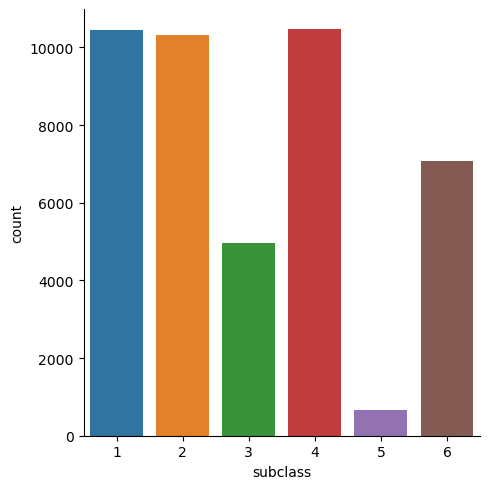

(10455, 56) (10318, 56) (4972, 56) (10467, 56) (668, 56) (7069, 56)


In [38]:
sns.catplot(x="subclass", kind="count", order=['1', '2', '3', '4', '5', '6'], data=tpall) # order: 보여지는 순서
plt.show()
# 분류항목 확인
for i in range(1, 7):
    globals()[f'sc{i}'] = tpall[tpall['subclass'] == str(i)]
print(sc1.shape, sc2.shape, sc3.shape, sc4.shape, sc5.shape, sc6.shape)

In [39]:
tpall.to_csv('./dataCSV/all_training_ver2.csv', index=False)

In [53]:
tpall
# result: 50437 rows × 46 columns

,subclass,NDVI0,NDVI1,NDVI2,NDVI3,NDVI4,NDVI5,NDVI6,NDVI7,NDVI8,...,YVI8,WBI0,WBI1,WBI2,WBI3,WBI4,WBI5,WBI6,WBI7,WBI8
0,3,0.464904,0.445488,0.473091,0.510326,0.492966,0.470867,0.462338,0.447882,0.465438,...,-0.025793,-0.023712,-0.024151,-0.021272,-0.016337,-0.019927,-0.023036,-0.022662,-0.022135,-0.021885
1,6,0.622866,0.627700,0.627700,0.592036,0.602341,0.619844,0.613144,0.607288,0.616141,...,-0.011950,-0.013503,-0.013142,-0.013142,-0.016172,-0.014747,-0.012225,-0.012940,-0.014615,-0.014480
2,6,0.485671,0.452899,0.387458,0.387458,0.414758,0.481439,0.531720,0.530093,0.536756,...,-0.015341,-0.024560,-0.025090,-0.033404,-0.033404,-0.030012,-0.020692,-0.019240,-0.022750,-0.019316
3,3,0.478828,0.475296,0.439229,0.440640,0.491810,0.556671,0.508831,0.528209,0.421745,...,-0.032468,-0.015789,-0.005387,-0.007839,-0.013497,-0.013025,-0.009255,-0.015647,-0.012939,-0.019699
4,3,0.377302,0.271617,0.244254,0.348663,0.406972,0.461839,0.504799,0.460585,0.377855,...,-0.015648,-0.022189,-0.031723,-0.038288,-0.025578,-0.025925,-0.025050,-0.020132,-0.018883,-0.021936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43944,5,0.475202,0.504286,0.522750,0.528241,0.496828,0.487972,0.433563,0.434048,0.468802,...,-0.037626,-0.020355,-0.017943,-0.015363,-0.015059,-0.018785,-0.016261,-0.023574,-0.024302,-0.022173
43945,6,0.460392,0.470885,0.493936,0.475196,0.422498,0.374210,0.355977,0.389782,0.453951,...,-0.020992,-0.028739,-0.021868,-0.023682,-0.030360,-0.033514,-0.038654,-0.038038,-0.028467,-0.024592
43946,5,0.707391,0.728033,0.728033,0.665958,0.695431,0.649497,0.640839,0.620106,0.642896,...,-0.020225,-0.004378,-0.002494,-0.002494,-0.007388,-0.005111,-0.009982,-0.011147,-0.013992,-0.010811
43947,6,0.505243,0.419842,0.480400,0.525081,0.530191,0.535845,0.439902,0.439902,0.430771,...,-0.029189,-0.008859,-0.016015,-0.010959,-0.007132,-0.009036,-0.008716,-0.016600,-0.016600,-0.016158


In [17]:
# td = up+br, test = down
tp_upbr = gpd.GeoDataFrame( pd.concat( [up, br], ignore_index=True) )
tp_upbr.drop(['geometry'], axis = 1, inplace=True)

In [22]:
tp_upbr.to_csv('upbr_training.csv', index=False)
down.to_csv('down_test.csv', index=False)

In [21]:
down

,subclass,NDVI0,NDVI1,NDVI2,NDVI3,NDVI4,NDVI5,NDVI6,NDVI7,NDVI8,...,YVI8,WBI0,WBI1,WBI2,WBI3,WBI4,WBI5,WBI6,WBI7,WBI8
1,1,0.610439,0.562178,0.585266,0.568741,0.607949,0.620719,0.624810,0.604821,0.591637,...,-0.009734,-0.013966,-0.018572,-0.016770,-0.017633,-0.014538,-0.012910,-0.011927,-0.012488,-0.014729
2,1,0.423846,0.494278,0.435812,0.404347,0.398452,0.407033,0.459979,0.482630,0.470416,...,-0.011459,-0.028486,-0.019441,-0.025333,-0.027976,-0.030023,-0.030338,-0.024822,-0.023420,-0.023403
8,1,0.315406,0.379775,0.377538,0.373157,0.291602,0.201947,0.253879,0.252509,0.320808,...,-0.010628,-0.018235,-0.016197,-0.016101,-0.016728,-0.014798,-0.022777,-0.021076,-0.021096,-0.017345
9,6,0.253490,0.229874,0.242919,0.242919,0.268116,0.249478,0.265961,0.255578,0.243387,...,-0.056597,-0.039669,-0.041651,-0.037001,-0.037001,-0.038725,-0.040039,-0.038853,-0.039195,-0.039457
10,1,0.634895,0.596301,0.596301,0.636861,0.667508,0.666212,0.667438,0.635335,0.621389,...,-0.025912,-0.006668,-0.010121,-0.010121,-0.007041,-0.003515,-0.002861,-0.002940,-0.006053,-0.007190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24112,4,0.710760,0.612913,0.699723,0.544407,0.566911,0.641944,0.786801,0.859582,0.811516,...,0.016995,-0.002253,-0.004717,-0.001604,-0.012341,-0.012663,-0.007631,0.000652,0.003226,0.002078
24113,2,0.247676,0.240268,0.244050,0.255254,0.256054,0.271645,0.276003,0.299487,0.256842,...,-0.019210,-0.030961,-0.023976,-0.026360,-0.026418,-0.029275,-0.026791,-0.026560,-0.022038,-0.026877
24121,1,0.413353,0.356041,0.330912,0.409870,0.391277,0.577737,0.481077,0.493339,0.450082,...,-0.021465,-0.026478,-0.029435,-0.024865,-0.006390,-0.022523,-0.010988,-0.021784,-0.024800,-0.026241
24123,3,0.275474,0.321883,0.309113,0.331701,0.286348,0.247396,0.257025,0.257025,0.275897,...,0.015586,-0.010896,-0.009838,-0.009900,-0.009174,-0.010831,-0.011616,-0.010849,-0.010849,-0.010575
